In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
import os
import numpy as np
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.measure import compare_ssim as ssim

Using TensorFlow backend.


In [2]:
# operations
def ev_binning(ev_t, ev_xyp, num_evf):
    ev_dim1 = 180
    ev_dim2 = 240
    evf = np.zeros((ev_dim1, ev_dim2, num_evf))
    t_min = np.amin(ev_t)
    t_max = np.amax(ev_t)
    dt = (t_max - t_min)/num_ev
    # t_grid = np.linspace(t_min, t_max, num_evf + 1)
    idx = 0
    for t in ev_t:
        xyp = ev_xyp[idx,:]
        fr_num = int(np.floor((t - t_min-1e-6)/dt))
        evf[xyp[1]][xyp[0]][fr_num] = (xyp[2]-0.5)*2
        idx = idx + 1
    return evf

def plot_color_evf(evf):
    dim1 = np.size(evf, 0)
    dim2 = np.size(evf, 1)
    neg_c = np.array([212, 20, 90])/255.
    pos_c = np.array([63, 169, 245])/255.
    canvas = np.ones((dim1, dim2, 3))*0.5
    for i in range(dim1):
        for j in range(dim2):
            if evf[i,j] == 1:
                canvas[i,j,:] = pos_c
            elif evf[i,j] == -1:
                canvas[i,j,:] = neg_c
    return canvas

In [3]:
# models
def init_hres(config, lres_gt):
    lres_gt_var = tf.Variable(lres_gt)
    # init hres
    if config.hres_init_type == 0:
        hres_partial = tf.Variable(tf.random_uniform(config.evf_dim))
        if config.lres_type == 0:
            print("hres initialized, frame 0 == reference")
            return tf.concat([lres_gt_var, hres_partial], 3)
        elif config.lres_type == 1:
            print("hres initialized, frame 1 == reference")
            return tf.concat([hres_partial, lres_gt_var], 3)
    elif config.hres_init_type == 1:
        for i in range(config.ev_dim):
            lres_gt_var = tf.concat([lres_gt_var, tf.Variable(lres_gt)], 3)
        print("hres initialized, ", np.shape(lres_gt_var))
        return lres_gt_var
    
def init_flow(config):
    if config.flow_init == 0:
        flow_x = tf.Variable(tf.zeros(config.hres_dim))
        flow_y = tf.Variable(tf.zeros(config.hres_dim))
        flow = tf.concat([flow_x, flow_y], 0)
        return flow
        
def frame_model(config, hres_tensor):
    hres_transpose = tf.transpose(hres_tensor, perm = [3,0,1,2])
    if config.lres_type == 0:
        lres_transpose = tf.gather_nd(hres_transpose, indices = [[0]])
    elif config.lres_type == 1:
        lres_transpose = tf.gather_nd(hres_transpose, indices = [[0]])
    return tf.transpose(lres_transpose, perm = [1,2,3,0])

def event_model(config, hres_tensor):
    hres_ndhwc = tf.expand_dims(hres_tensor, dim = 4)
    tanh_coef = tf.constant(config.tanh_coef)
    #kernel = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.constant([-1,1], dtype = tf.float32), dim = 1), dim = 0), dim = 0)
    #print(np.shape(hres_tensor))
    #print(np.shape(kernel))
    kernel = tf.constant([-1,1], dtype = tf.float32)
    kt = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.constant([-1,1], dtype = tf.float32), dim = 0), dim = 0), dim = 3), dim = 4)
    tf_evf = tf.tanh(tanh_coef*tf.nn.convolution(input = hres_ndhwc, filter = kt, padding = "VALID", data_format = "NDHWC"))
    return tf.squeeze(tf_evf, [4])

def tv_2d(config, hres_tensor):
    hres_ndhwc = tf.expand_dims(hres_tensor, dim = 4)
    kernel = tf.constant([-1,1], dtype = tf.float32)
    kx = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.constant([-1,1], dtype = tf.float32), dim = 1), dim = 2), dim = 3), dim = 4)
    ky = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.constant([-1,1], dtype = tf.float32), dim = 0), dim = 2), dim = 3), dim = 4)

    dx = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = kx, padding = "SAME", data_format = "NDHWC"), [4])
    dy = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = ky, padding = "SAME", data_format = "NDHWC"), [4])
    return tf.norm(dx+dy, ord = 1)

def tv_t(config, hres_tensor):
    hres_ndhwc = tf.expand_dims(hres_tensor, dim = 4)
    kernel = tf.constant([-1,1], dtype = tf.float32)
    kt = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.constant([-1,1], dtype = tf.float32), dim = 0), dim = 0), dim = 3), dim = 4)
    dt = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = kt, padding = "SAME", data_format = "NDHWC"), [4])
    return tf.norm(dt, ord = 1)

def flow_loss(config, hres_tensor, flow):
    flowx_tensor = tf.slice(flow, [0,0,0,0],[1,-1,-1,-1])
    flowy_tensor = tf.slice(flow, [1,0,0,0],[1,-1,-1,-1])
    hres_ndhwc = tf.expand_dims(hres_tensor, dim = 4)
    flowx_ndhwc = tf.expand_dims(flowx_tensor, dim = 4)
    flowy_ndhwc = tf.expand_dims(flowy_tensor, dim = 4)
    
    flow_coef_xy = tf.constant(config.flow_norm_xy_coef, dtype = tf.float32)
    flow_coef_t = tf.constant(config.flow_norm_t_coef, dtype = tf.float32)
    kernel = tf.constant([-1,1], dtype = tf.float32)
    
    kx = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, dim = 1), dim = 2), dim = 3), dim = 4)
    ky = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, dim = 0), dim = 2), dim = 3), dim = 4)
    kt = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, dim = 0), dim = 0), dim = 3), dim = 4)
    
    dHx = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = kx, padding = "SAME", data_format = "NDHWC"), [4])
    dHy = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = ky, padding = "SAME", data_format = "NDHWC"), [4])
    dHt = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = kt, padding = "SAME", data_format = "NDHWC"), [4])
    
    flow_eq = tf.multiply(dHx, flowx_tensor) + tf.multiply(dHy, flowy_tensor) + dHt
    
    dUxx = tf.squeeze(tf.nn.convolution(input = flowx_ndhwc, filter = kx, padding = "SAME", data_format = "NDHWC"), [4])
    dUxy = tf.squeeze(tf.nn.convolution(input = flowx_ndhwc, filter = ky, padding = "SAME", data_format = "NDHWC"), [4])
    dUyx = tf.squeeze(tf.nn.convolution(input = flowy_ndhwc, filter = kx, padding = "SAME", data_format = "NDHWC"), [4])
    dUyy = tf.squeeze(tf.nn.convolution(input = flowy_ndhwc, filter = ky, padding = "SAME", data_format = "NDHWC"), [4])
    dUxt = tf.squeeze(tf.nn.convolution(input = flowx_ndhwc, filter = kt, padding = "SAME", data_format = "NDHWC"), [4])
    dUyt = tf.squeeze(tf.nn.convolution(input = flowy_ndhwc, filter = kt, padding = "SAME", data_format = "NDHWC"), [4])
    
    return tf.norm(flow_eq, ord = 1) + flow_coef_xy*tf.norm(dUxx+dUxy+dUyx+dUyy, ord = 1)+ flow_coef_t*tf.norm(dUxt+dUyt, ord = 1)


def loss_all(config, ph, hres_tensor, lres_tensor, evf_tensor, flow_tensor):
    # frame_loss = tf.reduce_mean(tf.squared_difference(ph.lres_gt, lres_tensor))
    # event_loss = tf.constant(config.ev_weight)*tf.reduce_mean(tf.squared_difference(ph.evf_gt, evf_tensor))
    frame_loss = tf.norm(ph.lres_gt - lres_tensor, ord = 1)
    event_loss = tf.constant(config.ev_weight)*tf.norm(ph.evf_gt - evf_tensor, ord = 1)
    tv_loss = tf.constant(config.tv_coef_xy)*tv_2d(config, hres_tensor) + tf.constant(config.tv_coef_t)*tv_t(config, hres_tensor)
    opt_flow_loss = tf.constant(config.flow_loss_coef)*flow_loss(config, hres_tensor, flow_tensor)
    return frame_loss + event_loss + tv_loss + opt_flow_loss

def loss_no_flow(config, ph, hres_tensor, lres_tensor, evf_tensor):
    # frame_loss = tf.reduce_mean(tf.squared_difference(ph.lres_gt, lres_tensor))
    # event_loss = tf.constant(config.ev_weight)*tf.reduce_mean(tf.squared_difference(ph.evf_gt, evf_tensor))
    frame_loss = tf.norm(ph.lres_gt - lres_tensor, ord = 1)
    event_loss = tf.constant(config.ev_weight)*tf.norm(ph.evf_gt - evf_tensor, ord = 1)
    tv_loss = tf.constant(config.tv_coef_xy)*tv_2d(config, hres_tensor) + tf.constant(config.tv_coef_t)*tv_t(config, hres_tensor)
    return frame_loss + event_loss + tv_loss

(16418, 3)


<IPython.core.display.Javascript object>


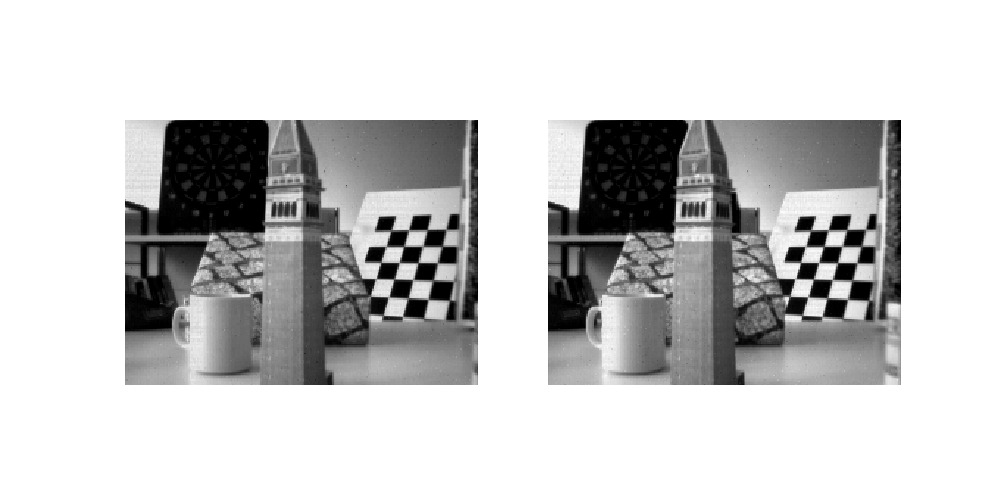

In [4]:
# load data
(hres, h_t, ev_t, ev_xyp) = np.load('tc_slider_depth_70_71.npy')
print(np.shape(ev_xyp))
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(hres[:,:,0], cmap = 'gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(hres[:,:,1], cmap = 'gray')
plt.axis('off')
plt.show()

In [20]:
num_ev = 20
evf = ev_binning(ev_t, ev_xyp, num_ev)

Max value 0.53, min value 0.00
('shape of hres_gt', (1, 180, 240, 2))
('shape of lres_gt', (1, 180, 240, 1))
('shape of evf_gt', (1, 180, 240, 20))


<IPython.core.display.Javascript object>


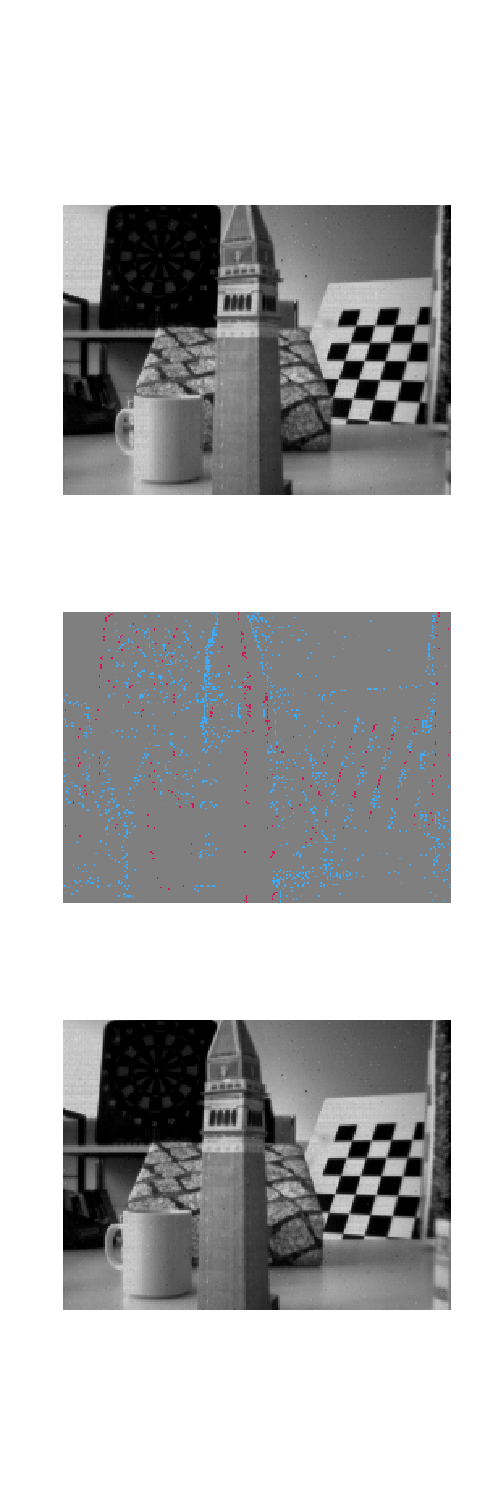

In [21]:
hres_gt = np.expand_dims(hres, axis = 0)
lres_gt = np.expand_dims(np.expand_dims(hres[:,:,0], axis = 2), axis = 0)
evf_gt = np.expand_dims(evf, axis = 0)
print("Max value %0.2f, min value %0.2f" % (np.amax(hres_gt), np.amin(hres_gt)))
print("shape of hres_gt", np.shape(hres_gt))
print("shape of lres_gt", np.shape(lres_gt))
print("shape of evf_gt",np.shape(evf_gt))
plt.figure(figsize = (5,15))
plt.subplot(311)
plt.imshow(np.squeeze(lres_gt),cmap='gray')
plt.clim(0,0.6)
plt.axis('off')
plt.subplot(312)
if num_ev == 1:
    #plt.imshow(np.squeeze(-evf),cmap='jet')
    #plt.clim(-1.6,1.6)
    #plt.axis('off') 
    evf_plt = plot_color_evf(np.squeeze(evf))
    plt.imshow(evf_plt)
    plt.axis('off')
else:
    #plt.imshow(np.squeeze(evf[:,:,-1]),cmap='jet')
    evf_plt = plot_color_evf(evf[:,:,-1])
    plt.imshow(evf_plt)
    plt.axis('off')
plt.subplot(313)
plt.imshow(np.squeeze(hres_gt[:,:,:,1]),cmap='gray')
plt.clim(0,0.6)
plt.axis('off')
plt.show()

In [51]:
# config
class config():
    def __init__(self, dim = None, ev_dim = 1):
        if dim == None:
            self.dim1 = 180
            self.dim2 = 240
        else:
            self.dim1, self.dim2 = dim
        self.ev_dim = ev_dim
        self.hres_dim = (1, self.dim1, self.dim2, self.ev_dim + 1)
        self.lres_dim = (1, self.dim1, self.dim2, 1)
        self.evf_dim = (1, self.dim1, self.dim2, self.ev_dim)
        # frames
        self.hres_init_type = 1 # 0: initialize from random 1: initialize from lr video
        self.lres_type = 0  # 0: start frame; 1: end frame
        
        # events
        self.ev_weight = 1e-1
        self.tanh_coef = 15.0
        
        # hres_tv
        self.tv_coef_xy = 3e-3
        self.tv_coef_t = 2e-1
        
        # flow
        self.flow_init = 0# Initialization
        self.flow_norm_xy_coef = 1e-1
        self.flow_norm_t_coef = 1e-1
        self.flow_loss_coef = 0.0#1e-1

        # learning
        self.lr = 0.007
        self.lr_decay = 0.9
        self.epochs = 101
        self.beta1 = 0.9
        self.beta2 = 0.99

def lr_schedule(config, epoch):
    fac = 0.96
    if epoch % 100 == 0:
        config.lr = config.lr*fac
    return config
# place holder
class place_holder():
    def __init__(self, config):
        self.learning_rate = tf.placeholder(tf.float32)
        self.lres_gt = tf.placeholder(tf.float32, shape = config.lres_dim)
        self.evf_gt = tf.placeholder(tf.float32, shape = config.evf_dim)

In [52]:
dim = (180,240)
res_config = config(dim, np.size(evf, 2))
res_ph = place_holder(res_config)

hres_tensor = init_hres(res_config, lres_gt)
flow_tensor = init_flow(res_config)
lres_tensor = frame_model(res_config, hres_tensor)
evf_tensor = event_model(res_config, hres_tensor)
loss = loss_no_flow(res_config, res_ph, hres_tensor, lres_tensor, evf_tensor)

optimizer = tf.train.AdamOptimizer(learning_rate = res_ph.learning_rate, beta1 = res_config.beta1, beta2 = res_config.beta2)
opt_min = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

iloss = np.empty((res_config.epochs,))
for iepoch in range(res_config.epochs):
    hres_rec, iloss[iepoch], flow_rec, _ = sess.run([hres_tensor, loss, flow_tensor, opt_min],
                               feed_dict={res_ph.lres_gt: lres_gt, 
                                          res_ph.evf_gt: evf_gt, 
                                          res_ph.learning_rate: res_config.lr})
    if iepoch % 50 == 0:
        res_config.lr = res_config.lr*0.9
        
        hres_gt1 = np.squeeze(hres_gt[:,:,:,1])
        hres1 = np.squeeze(hres_rec[:,:,:,1])
        hres1_ssim = ssim(hres_gt1,hres1)
        print "Epoch---->", iepoch, "  loss---->", iloss[iepoch], "  SSIM---->", hres1_ssim

print("Max value %0.2f, min value %0.2f" % (np.amax(hres_rec), np.amin(hres_rec)))

('hres initialized, ', TensorShape([Dimension(1), Dimension(180), Dimension(240), Dimension(21)]))
Epoch----> 0   loss----> 3703.27685546875   SSIM----> 0.6757558796407072
Epoch----> 50   loss----> 4988.6181640625   SSIM----> 0.6660040920421556
Epoch----> 100   loss----> 4552.38916015625   SSIM----> 0.6646786446752522
Max value 0.57, min value -0.11


<IPython.core.display.Javascript object>


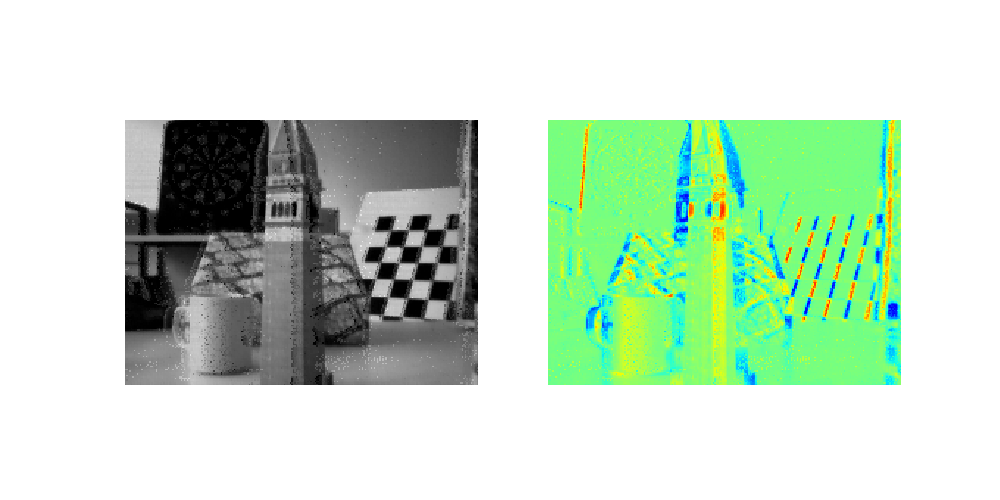

('Error max', 0.38498634)
('Error min', -0.407196)


In [53]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(np.squeeze(hres_rec[:,:,:,-1]),cmap='gray')
plt.clim(0,0.6)
plt.axis('off')
plt.show()
plt.subplot(122)
plt.imshow(np.squeeze(hres_rec[:,:,:,-1]-hres_gt[:,:,:,-1]), cmap='jet')
plt.clim(-0.5,0.5)
plt.axis('off')
plt.show()
err_max = np.amax(hres_rec[:,:,:,-1]-hres_gt[:,:,:,-1])
err_min = np.amin(hres_rec[:,:,:,-1]-hres_gt[:,:,:,-1])
print("Error max", err_max)
print("Error min", err_min)